### FCNN Model Loop with Skill Score calculation

File recreated on 6/26/2025 for the "updated" model. 

I will start with a 14 day model. 

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
import random
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import TimeSeriesSplit
import xarray as xr

import pickle

import warnings
warnings.filterwarnings("ignore")

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

import shap
import pylab
#tf.compat.v1.disable_eager_execution()
#import investigate

2025-06-26 17:24:04.467043: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 17:24:04.469031: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 17:24:04.495546: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-26 17:24:04.495567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-26 17:24:04.495587: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
from StatScores import BSS
from StatScores import RAS_two
from StatScores import PAS_two

### Inputs.

In [3]:
##load in solvers for PC analysis to get the PCs for the model itself. 

In [4]:
#load input data
infile = open("../eof_data/vertanom_u.p","rb",)
u_input = pickle.load(infile)  ##vertical U cross section
#flat_u_14 = u_input[:62, 19:168, :, :].reshape((62 * 149, 37, 36))
infile.close()

infile = open("../eof_data/vertanom_ehf.p","rb",)
ehf_input = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
#flat_EHF_14 = ehf_input[:62, 19:168, :, :].reshape((62 * 149, 37, 180))
infile.close()

infile = open("../eof_data/vertanom_gph.p","rb",)
gph_input = pickle.load(infile)  ##GPH vertical cross section along longitudes
#flat_GPH_14= gph_input[:62, 19:168, :, :].reshape((62 * 149, 37, 180))
infile.close()

##19:168 for 14 days and 
##19:162 for 20 days and 
##19:152 for 30 days. 

u_14 = u_input[:62, 19:168, :, :]
EHF_14 = ehf_input[:62, 19:168, :, :]
GPH_14= gph_input[:62, 19:168, :, :]

print("U Wind shape: ",u_14.shape)
print("EHF shape: ",EHF_14.shape)
print("GPH shape: ",GPH_14.shape)

U Wind shape:  (62, 149, 37, 36)
EHF shape:  (62, 149, 37, 180)
GPH shape:  (62, 149, 37, 180)


### Outputs. 

In [5]:
# load output data
# 149 for 14
# 143 for 20 and 
# 133 for 30 

infile = open("../reduced_data/temps/eur_14.p","rb",)
output = pickle.load(infile) 
output = output.reshape(62, 149)
infile.close()

In [6]:
# load climo data
infile = open("../reduced_data/climo/eur_climo14.p","rb",)
climo = pickle.load(infile) 
infile.close()

In [7]:
lead = 149

temp = output[:,:]
print(temp.shape)

climo = climo.reshape(62, 149, 2)
climo = climo[:, :, :]
#climo = climo.reshape(8370,2)

print("climo: ",climo.shape)
print("output: ",temp.shape)

(62, 149)
climo:  (62, 149, 2)
output:  (62, 149)


In [8]:
#this can be commented out if not needed. 
input_u =  u_14
input_ehf =  EHF_14
input_gph =  GPH_14
temp_n = temp
new_climo = climo.reshape(62*149,2)

In [9]:
frac_ind = round((62*lead)*0.15)
frac_end = round((62*lead)-frac_ind)

print("testing and validation size: ",frac_ind)
print("training size: ",frac_end)

testing and validation size:  1386
training size:  7852


In [10]:
##Set X_all and Y_all datasets
X_all1 = np.copy(input_u.reshape(62*lead,37*36)) ##u
X_all2 = np.copy(input_ehf.reshape(62*lead,37*180)) ##ehf
X_all3 = np.copy(input_gph.reshape(62*lead,37*180)) ##gph

Y_all = np.copy(temp_n.reshape(62*lead))

##training data partition out
X_tri1 = X_all1[:frac_end,:] ##u
X_tri2 = X_all2[:frac_end,:] ##ehf
X_tri3 = X_all3[:frac_end,:] ##gph

Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes1 = X_all1[frac_end:,:]
X_tes2 = X_all2[frac_end:,:]
X_tes3 = X_all3[frac_end:,:]

Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [11]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all1)) or np.any(np.isinf(X_all1)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [12]:
##number of input nodes
input_shape1=  X_all1.shape[-1] # u
input_shape2= X_all2.shape[-1] ## ehf
input_shape3= X_all3.shape[-1] ## gph

print(input_shape1)
print(input_shape2)
print(input_shape3)

1332
6660
6660


In [13]:
########
#CHANGE BASED ON NUMBER OF FOLDS FOR TIMESERIES SPLIT
n = 20

In [14]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [15]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [16]:
##Loss and ACC lists, only relevant w/o early stopping
train_loss = []
val_loss = []
cat_acc = []
val_acc = [] 

##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((n,))
BSS_val= np.empty((n,))
BSS_train= np.empty((n,))
BSS_test= np.empty((n,))
BSS_90= np.empty((n,))

BSS_avg= np.empty((n,))
BSS_30= np.empty((n,))
BSS_70= np.empty((n,))

##RAS and PAS Arrays
Prec_all= np.empty((n,2))
Rec_all= np.empty((n,2))

Prec_val= np.empty((n,2))
Rec_val= np.empty((n,2))

Prec_train= np.empty((n,2))
Rec_train= np.empty((n,2))

Prec_test= np.empty((n,2))
Rec_test= np.empty((n,2))


In [17]:
##empty lists for ACC scores 
##Testing Accuracy Arrays
fulltest_acc = []
test90_acc = []

##Training Accuracy Arrays
fulltrain_acc = []
train90_acc = []

##Validation Accuracy Arrays
fullval_acc = []
val90_acc = []

In [18]:
##probabilities
p_test = []
p_train = []
p_val = []

p_mid = []
p_90 = []
p_30 = []
p_70 = []

##correct positive
posXtest = []
#false positive
FposXtest = []
#correct negative
negXtest = []
#false negative
FnegXtest = []

index90 = []
indexmin = []
indexmid = []
indexmax = []

##correct positive
percpos = []
#false positive
percFpos = []
#correct negative
percneg = []
#false negative
percFneg = []

### Model Architecture. 

In [19]:
def train_datasubset(data,start,end):
    train1 = data[0:start]
    train2 = data[end:]
    train = np.concatenate((train1,train2))
    return train;

In [20]:
######
batch_size = 256
epochs = 50
shuffle = True
verbose = 0 #0 returns no apoch info, 2 does

In [21]:
def combined(n1, n2, n3, n4, n5, n6, n7, reg1, reg2, reg3, reg4, reg5, reg6, reg7, learn):
    ##first layers for U ANN
    input_tensor1 = Input(shape=(int(1332),), name='layer1')
    layer1 = layers.Dense(n1, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg1))(input_tensor1)
   

    layer1 = layers.Dense(n2, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg2))(layer1)
   
    ## second layers for EHF ANN
    input_tensor2 = Input(shape=(int(6660),), name='layer2')
    layer2 = layers.Dense(n3, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg3))(input_tensor2)
    
    layer2 = layers.Dense(n4, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg4))(layer2)
    
    
    ## third layers for GPH ANN
    input_tensor3 = Input(shape=(int(6660),), name='layer3')
    layer3 = layers.Dense(n5, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg5))(input_tensor3)
    
    layer3 = layers.Dense(n6, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg6))(layer3)
    
    ##combine two model inputs
    merge_layer = Concatenate()([layer1,layer2,layer3])

    ##more dense layers
    merge = layers.Dense(n7, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg7))(merge_layer)

    #decay_rate = learn / epochs
    output_tensor = layers.Dense(2,activation='softmax')(merge)
    model = Model([input_tensor1, input_tensor2, input_tensor3], output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [22]:
##Early Stopping Condition, if desired
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1)

In [ ]:
## create loop for cross validation
for l in range(0,n):
    print("#######################################")
    print("CV ",l)
    tf.keras.backend.clear_session()
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_tri1[:,0])-frac_ind)
    end = start+(frac_ind)

    #choose random 15% window of training data to be used for validation
    X_val1 = X_tri1[start:end]
    X_val2 = X_tri2[start:end]
    X_val3 = X_tri3[start:end]
    
    Y_val = Y_tri[start:end]

    #remaining training data
    X_tr1 = train_datasubset(X_tri1,start,end)
    X_tr2 = train_datasubset(X_tri2,start,end)
    X_tr3 = train_datasubset(X_tri3,start,end)
    
    Y_tr = train_datasubset(Y_tri,start,end)
    
    ##dictionaries for training and validation
    X_tr = {'layer1': X_tr1, 'layer2': X_tr2, 'layer3': X_tr3}
    X_all = {'layer1': X_all1, 'layer2': X_all2, 'layer3': X_all3}
    X_tes = {'layer1': X_tes1, 'layer2': X_tes2, 'layer3': X_tes3}
    X_val = {'layer1': X_val1, 'layer2': X_val2, 'layer3': X_val3}
    
    ##calculate class weights on remaining training data
    class_weight = class_weight_creator(Y_tr)

    ##same partitioning for climo data
    climo_train1 = new_climo[0:start,:]
    climo_train2 = new_climo[end:frac_end,:]
    
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    ##pause, calculate climo probabilities
    climo_val = new_climo[start:end,:]
    climo_test = new_climo[frac_end:,:]
    
    #initalize model
    model = combined(n1 = 128, 
                 n2 = 16, 
                 n3 = 128, 
                 n4 = 16, 
                 n5 = 128,
                 n6 = 16,
                 n7 = 24,
                 reg1 = 0.05, 
                 reg2 = 0.015, 
                 reg3 = 0.05, 
                 reg4 = 0.015,
                 reg5 = 0.05, 
                 reg6 = 0.015,
                 reg7 = 0.0525,
                 learn =0.1735 )
    
    model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val), verbos
          batch_size=batch_size, epochs=epochs, shuffle=shuffle,class_weight = class_weight, callbacks=[early_stopping])
    
    train_loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    cat_acc.append(model.history.history['categorical_accuracy'])
    val_acc.append(model.history.history['val_categorical_accuracy'])
    
    pred = model.predict(X_all)
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_tes)
    
    p_train.extend(pred_train)
    p_val.extend(pred_val)
    p_test.extend(pred_test)
    ########################################################################################################
    ##STATISTICS CALCULATINNG
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []
    
    ##BRIER SKILL SCORE
    BSS_all[l] = BSS(Y_all,pred)
    BSS_val[l] = BSS(Y_val,pred_val)
    BSS_train[l] = BSS(Y_tr,pred_train)
    BSS_test[l] = BSS(Y_tes,pred_test) 
    
    ##RECALL ACCURACY SCORE    
    RAS_two(l, Rec_all, new_climo, Y_all, pred, pred_class,
            climo_val, Rec_val, Y_val, pred_val, predval_class,
            climo_train, Rec_train, Y_tr, pred_train, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS_two(l, Prec_all, new_climo, Y_all, pred, pred_class,
            climo_val, Prec_val, Y_val, pred_val, predval_class,
            climo_train, Prec_train, Y_tr, pred_train, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test, predtest_class)
    ########################################################################################################
    ##ACC
    ##TESTING
    q90 = np.percentile(pred_test,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = pred_test[great90]
    test90_norm = Y_tes[great90]
    test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
    ##full model
    fulltest_acc.append(calculate_accuracy(Y_tes, pred_test, threshold=0.5))
    ##Greater than 90 BSS
    climo_90 = climo_test[great90]
    
    BSS_90[l] = BSS(test90_norm,test90)
    p_90.extend(test90)
    
    ##classify the accuracy of predicitons
    correct_pos = [] #correct positive anomaly
    correct_neg = [] #correct negative anomaly
    
    false_pos = [] #false positive
    false_neg = [] #false negative

    for j in range(len(great90)):
        #print(j)
        #print(great90[j])
        index = great90[j]
        if pred_test[index,0] < pred_test[index,1] and Y_tes[index,0] == 0:
            correct_pos.append(index)
            #print('###########')
        elif pred_test[index,0] > pred_test[index,1] and Y_tes[index,0] == 1:
            correct_neg.append(index)
            #print('###########')
        elif pred_test[index,0] < pred_test[index,1] and Y_tes[index,0] == 1:
            false_neg.append(index)
            #print('###########')
        elif pred_test[index,0] > pred_test[index,1] and Y_tes[index,0] == 0:
            false_pos.append(index)
            #print('###########')

    ##correct positive
    posXtest.extend(correct_pos)
    #false positive
    FposXtest.extend(false_pos)
    #correct negative
    negXtest.extend(correct_neg)
    #false negative
    FnegXtest.extend(false_neg)
    
    percpos.append(len(correct_pos)/len(great90))
    #false positive
    percFpos.append(len(false_pos)/len(great90))
    #correct negative
    percneg.append(len(correct_neg)/len(great90))
    #false negative
    percFneg.append(len(false_neg)/len(great90))


    ##############################3
    
    #AVERAGE QUANT
    qmin = np.min(pred_test,axis=0)
    q30 = np.percentile(pred_test,30,axis=0) ##30th percentile of test
    q70 = np.percentile(pred_test,70,axis=0) ##70th percentile of test
    qmax = np.max(pred_test,axis=0)
    
    ##mid percentile acc
    mid = [i for i, row in enumerate(pred_test) if (row[0] >= q30[0] and row[0] <= q70[0] ) or (row[1] >= q30[1] and row[1] <= q70[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test_mid = pred_test[mid]
    test_mid_norm = Y_tes[mid]
    
    BSS_avg[l] = BSS(test_mid_norm,test_mid)
    p_mid.extend(test_mid)
    
    #0-30
    minimum = [i for i, row in enumerate(pred_test) if (row[0] >= qmin[0] and row[0] < q30[0] ) or (row[1] >= qmin[1] and row[1] < q30[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test_minimum = pred_test[minimum]
    test_minimum_norm = Y_tes[minimum]
    
    BSS_30[l] = BSS(test_minimum_norm,test_minimum)
    p_30.extend(test_minimum)
    
    #70-100
    maximum = [i for i, row in enumerate(pred_test) if (row[0] > q70[0] and row[0] <= qmax[0] ) or (row[1] > q70[1] and row[1] <= qmax[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test_maximum = pred_test[maximum]
    test_maximum_norm = Y_tes[maximum]
    
    BSS_70[l] = BSS(test_maximum_norm,test_maximum)
    p_70.extend(test_maximum)
    
    ####_______SAVE INDICES _______
    index90.extend(great90)
    indexmin.extend(minimum)
    indexmid.extend(mid)
    indexmax.extend(maximum)

#######################################
CV  0
Epoch 1/50
26/26 [==============================] - 1s 29ms/step - loss: 325625.3750 - categorical_accuracy: 0.5456 - val_loss: 56428.9883 - val_categorical_accuracy: 0.5483
Epoch 2/50
26/26 [==============================] - 0s 19ms/step - loss: 78039.0547 - categorical_accuracy: 0.5571 - val_loss: 32201.9277 - val_categorical_accuracy: 0.6270
Epoch 3/50
26/26 [==============================] - 0s 19ms/step - loss: 20466.2676 - categorical_accuracy: 0.5892 - val_loss: 6908.0601 - val_categorical_accuracy: 0.6248
Epoch 4/50
26/26 [==============================] - 0s 19ms/step - loss: 5231.3896 - categorical_accuracy: 0.6052 - val_loss: 2265.6018 - val_categorical_accuracy: 0.5945
Epoch 5/50
26/26 [==============================] - 0s 19ms/step - loss: 1758.5034 - categorical_accuracy: 0.5985 - val_loss: 1379.9431 - val_categorical_accuracy: 0.5707
Epoch 6/50
26/26 [==============================] - 1s 20ms/step - loss: 1038.6171 - categori

In [ ]:
##correct positive
posXtest = np.array(posXtest)
#false positive
FposXtest = np.array(FposXtest)
#correct negative
negXtest = np.array(negXtest)
#false negative
FnegXtest = np.array(FnegXtest)

print(f'Average Num. of 10% Confident and Correct Postive Predictions: {np.mean(percpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and Correct Negative Predictions: {np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Postive Predictions: {np.mean(percFpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Negative Predictions: {np.mean(percFneg)* 100:.2f}%')
print('#######################################################################')
print(f'Average Num. of 10% Confident and Correct Predictions: {np.mean(percpos)* 100 + np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Predictions: {np.mean(percFpos)* 100 +np.mean(percFneg)* 100:.2f}%')

Text(0.5, 1.0, 'BSS for 90th Percentile Predictions of Testing Data in 100 CVs')

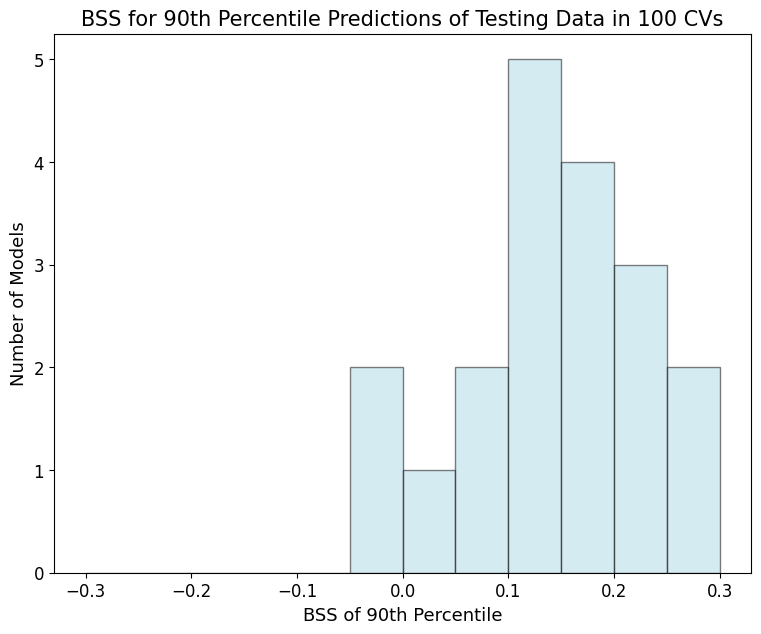

In [29]:
bins = np.linspace(-0.3, 0.3,13)
counts, edges, = np.histogram(BSS_90[:], bins=bins)

fig, (ax1) = plt.subplots(1,1, figsize=(9,7))

ax1.bar(edges[:-1], counts, width=np.diff(edges), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax1.set_xlabel('BSS of 90th Percentile',fontsize =13)
ax1.set_ylabel('Number of Models',fontsize =13)
plt.tick_params(labelsize = 12)
ax1.set_title('BSS for 90th Percentile Predictions of Testing Data in 100 CVs',fontsize =15)
#plt.savefig("BSS90_eur14.png")

Text(0.525, 0.95, 'BSS of Predictions in Various Percentiles of Testing Data in 100 CVs for Predicting +14 day European Temp Anomalies')

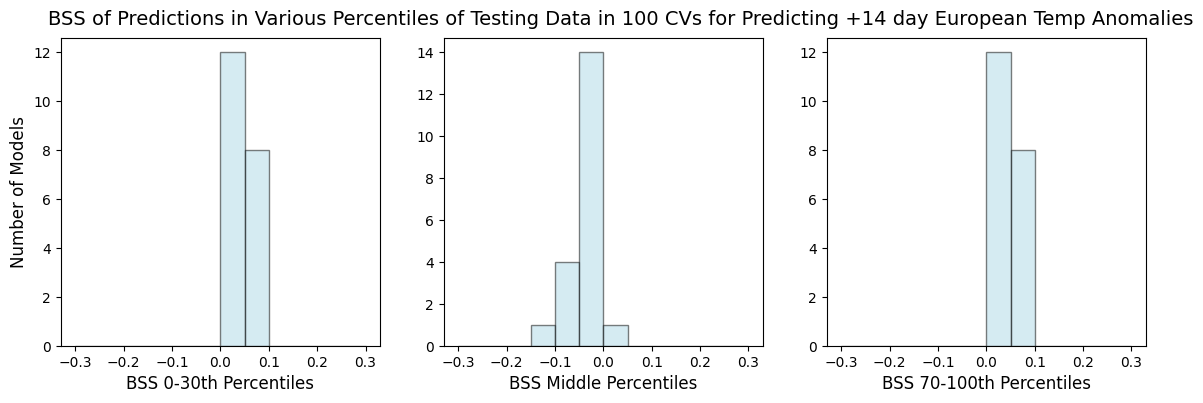

In [30]:
bins = np.linspace(-0.3, 0.3,13)
fs = 11

counts1, edges1, = np.histogram(BSS_30[:], bins=bins)
counts2, edges2, = np.histogram(BSS_avg[:], bins=bins)
counts3, edges3, = np.histogram(BSS_70[:], bins=bins)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,4))

ax1.bar(edges1[:-1], counts1, width=np.diff(edges1), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax1.set_xlabel('BSS 0-30th Percentiles', fontsize=fs+1)
ax1.set_ylabel('Number of Models', fontsize=fs+1)

ax2.bar(edges2[:-1], counts2, width=np.diff(edges2), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax2.set_xlabel('BSS Middle Percentiles', fontsize=fs+1)
#ax2.set_ylabel('Number of Models', fontsize=fs+1)

ax3.bar(edges3[:-1], counts3, width=np.diff(edges3), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax3.set_xlabel('BSS 70-100th Percentiles', fontsize=fs+1)
#ax3.set_ylabel('Number of Models', fontsize=fs+1)

plt.suptitle('BSS of Predictions in Various Percentiles of Testing Data in 100 CVs for Predicting +14 day European Temp Anomalies', fontsize=fs+3, x=0.525,y=0.95)
#plt.savefig("BSSpercentile_eur14.png")

Text(0.525, 0.95, 'BSS of Predictions Across All Datasets in 100 CVs for Predicting +14 day European Temp Anomalies')

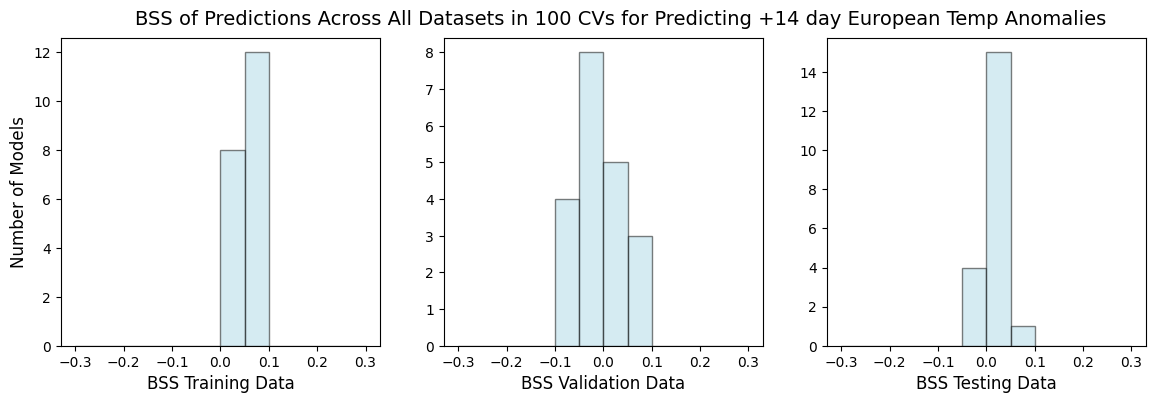

In [31]:
bins = np.linspace(-0.3, 0.3,13)
fs = 11

counts1, edges1, = np.histogram(BSS_train[:], bins=bins)
counts2, edges2, = np.histogram(BSS_val[:], bins=bins)
counts3, edges3, = np.histogram(BSS_test[:], bins=bins)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,4))

ax1.bar(edges1[:-1], counts1, width=np.diff(edges1), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax1.set_xlabel('BSS Training Data', fontsize=fs+1)
ax1.set_ylabel('Number of Models', fontsize=fs+1)

ax2.bar(edges2[:-1], counts2, width=np.diff(edges2), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax2.set_xlabel('BSS Validation Data', fontsize=fs+1)
#ax2.set_ylabel('Number of Models', fontsize=fs+1)

ax3.bar(edges3[:-1], counts3, width=np.diff(edges3), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax3.set_xlabel('BSS Testing Data', fontsize=fs+1)
#ax3.set_ylabel('Number of Models', fontsize=fs+1)

plt.suptitle('BSS of Predictions Across All Datasets in 100 CVs for Predicting +14 day European Temp Anomalies', fontsize=fs+3, x=0.525,y=0.95)
#plt.savefig("BSSdatasets_eur14.png")

In [32]:
len(p_train)

117160

In [33]:
p_test = np.array(p_test)
p_test = p_test.reshape(((len(p_test),2)))

p_train = np.array(p_train)
p_train = p_train.reshape(((len(p_train),2)))

p_val= np.array(p_val)
p_val = p_val.reshape(((len(p_val),2)))

p_mid= np.array(p_mid)
p_mid = p_mid.reshape(((len(p_mid),2)))

p_30= np.array(p_30)
p_30 = p_30.reshape(((len(p_30),2)))

p_70= np.array(p_70)
p_70 = p_70.reshape(((len(p_70),2)))

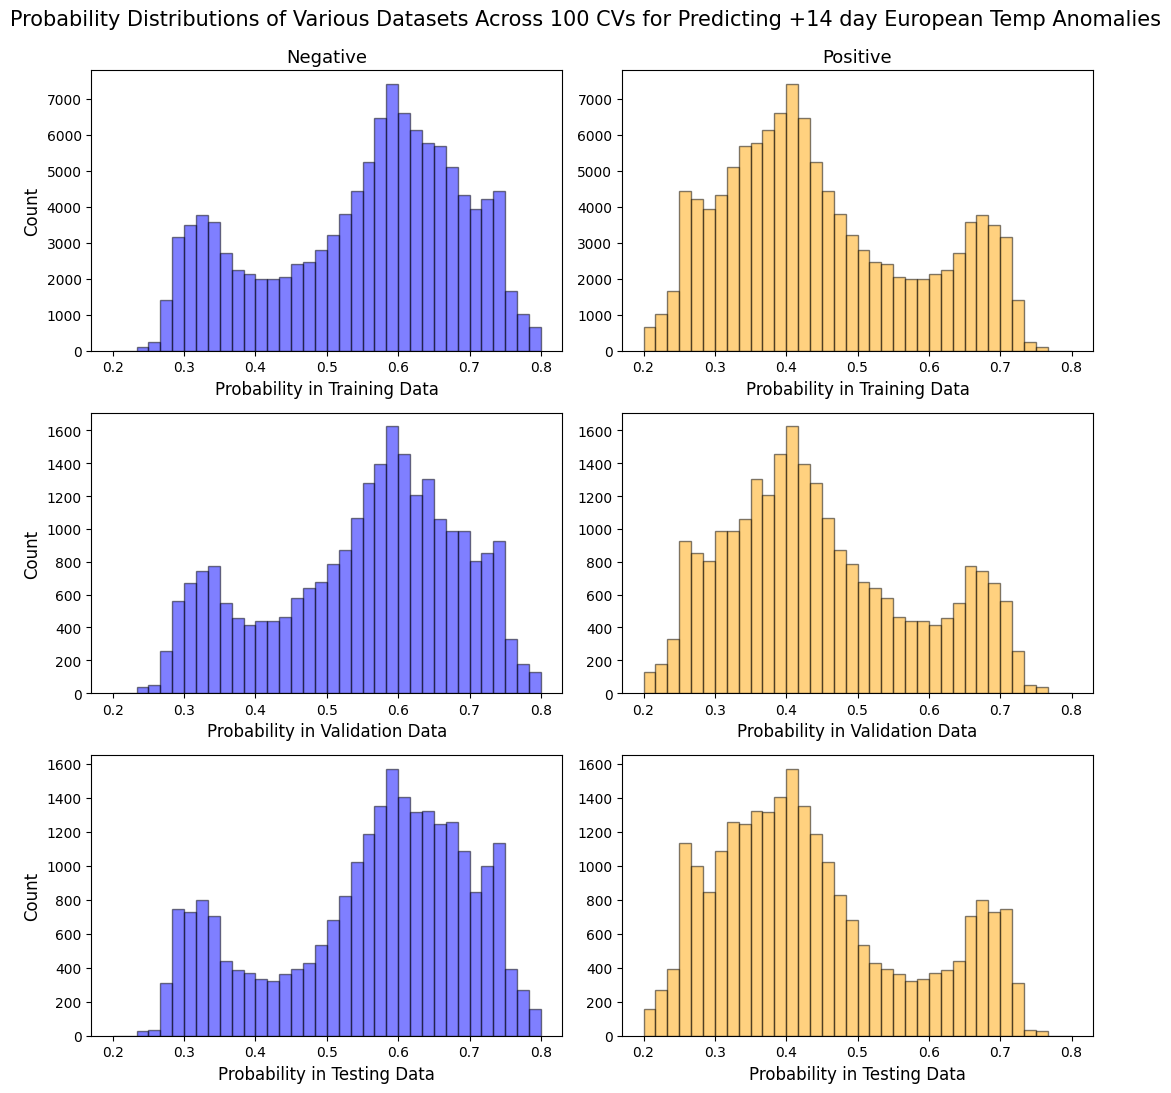

In [34]:
bins = np.linspace(0.2, 0.8, 37)  #10 bins from 0.4 to 1
fs = 11
##bin the probabilities
counts_neg_train, edges_neg_train = np.histogram(p_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(p_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(p_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(p_val[:,1], bins=bins)

counts_neg_test, edges_neg_test = np.histogram(p_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(p_test[:,1], bins=bins)


fig, axes = plt.subplots(3, 2, figsize=(11,11))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative', fontsize=fs+2)
ax1.set_xlabel('Probability in Training Data', fontsize=fs+1)
ax1.set_ylabel('Count', fontsize=fs+1)

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive', fontsize=fs+2)
ax2.set_xlabel('Probability in Training Data', fontsize=fs+1)
#ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax3.set_title('Negative Validation Predictions', fontsize=fs)
ax3.set_xlabel('Probability in Validation Data', fontsize=fs+1)
ax3.set_ylabel('Count', fontsize=fs+1)

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax4.set_title('Positive Validation Predictions', fontsize=fs)
ax4.set_xlabel('Probability in Validation Data', fontsize=fs+1)
#ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax5.set_title('Negative Testing Predictions', fontsize=fs)
ax5.set_xlabel('Probability in Testing Data', fontsize=fs+1)
ax5.set_ylabel('Count', fontsize=fs+1)

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax6.set_title('Positive Testing Predictions', fontsize=fs)
ax6.set_xlabel('Probability in Testing Data', fontsize=fs+1)
#ax6.set_ylabel('Count')

plt.suptitle("Probability Distributions of Various Datasets Across 100 CVs for Predicting +14 day European Temp Anomalies", fontsize=fs+4, x=0.525,y=0.99)
plt.tight_layout()
#plt.savefig("probability_distrib_eur14.png")

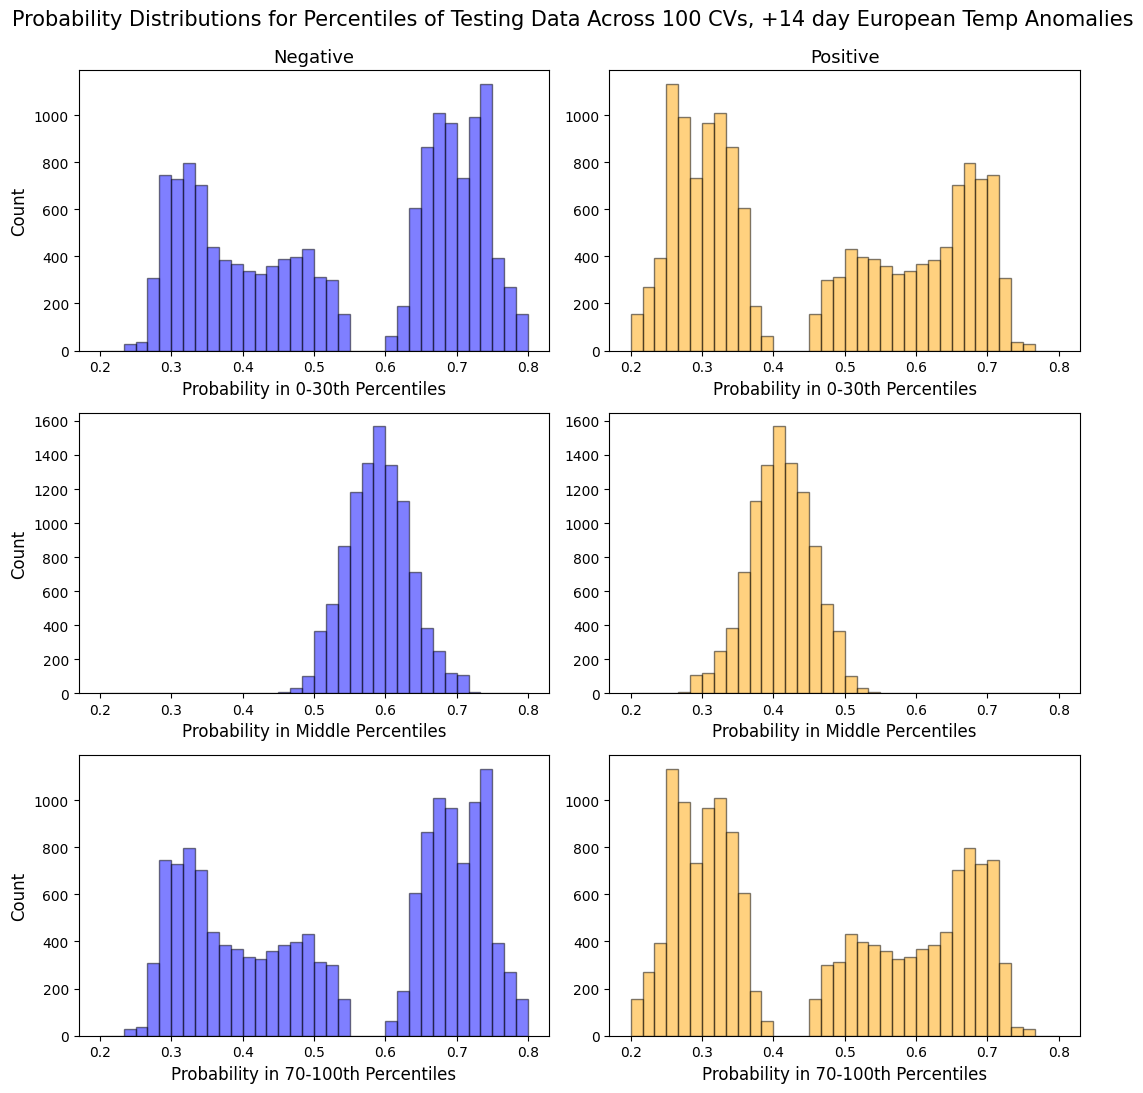

In [35]:
bins = np.linspace(0.2, 0.8, 37)  #10 bins from 0.4 to 1
fs = 11
##bin the probabilities
counts_neg_train, edges_neg_train = np.histogram(p_30[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(p_30[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(p_mid[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(p_mid[:,1], bins=bins)

counts_neg_test, edges_neg_test = np.histogram(p_70[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(p_70[:,1], bins=bins)


fig, axes = plt.subplots(3, 2, figsize=(11,11))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative', fontsize=fs+2)
ax1.set_xlabel('Probability in 0-30th Percentiles', fontsize=fs+1)
ax1.set_ylabel('Count', fontsize=fs+1)

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive', fontsize=fs+2)
ax2.set_xlabel('Probability in 0-30th Percentiles', fontsize=fs+1)
#ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax3.set_title('Negative Validation Predictions', fontsize=fs)
ax3.set_xlabel('Probability in Middle Percentiles', fontsize=fs+1)
ax3.set_ylabel('Count', fontsize=fs+1)

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax4.set_title('Positive Validation Predictions', fontsize=fs)
ax4.set_xlabel('Probability in Middle Percentiles', fontsize=fs+1)
#ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax5.set_title('Negative Testing Predictions', fontsize=fs)
ax5.set_xlabel('Probability in 70-100th Percentiles', fontsize=fs+1)
ax5.set_ylabel('Count', fontsize=fs+1)

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax6.set_title('Positive Testing Predictions', fontsize=fs)
ax6.set_xlabel('Probability in 70-100th Percentiles', fontsize=fs+1)
#ax6.set_ylabel('Count')

plt.suptitle("Probability Distributions for Percentiles of Testing Data Across 100 CVs, +14 day European Temp Anomalies", fontsize=fs+4, x=0.525,y=0.99)
plt.tight_layout()
#plt.savefig("percentile_distrib_eur14.png")

### Model Curves. 

### Skill Score Distributions. 

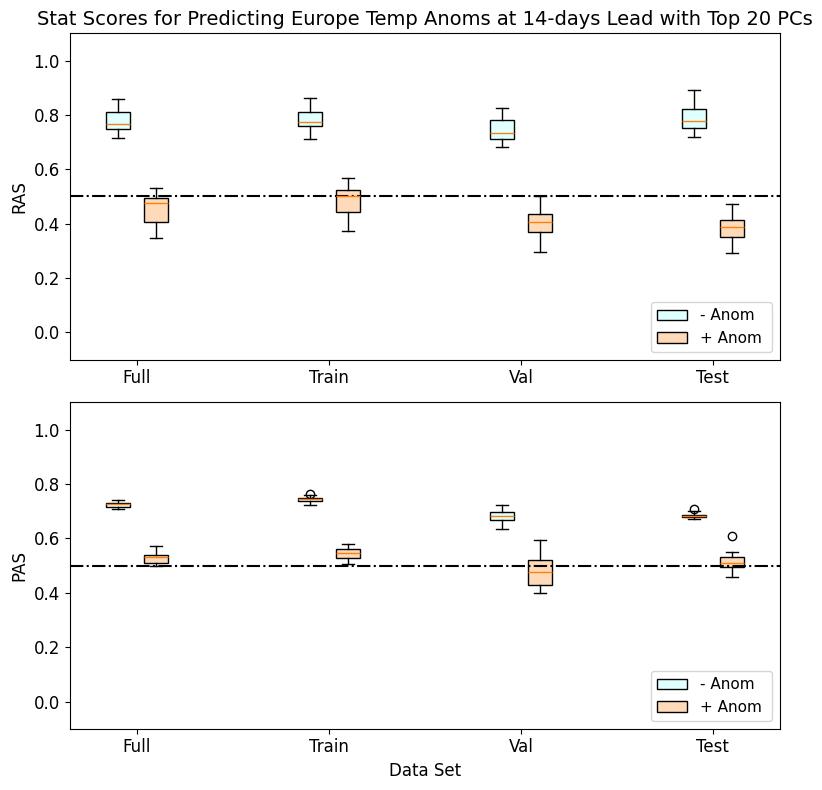

In [36]:
#plot
fig = plt.figure(figsize=(8,8))
font = 12
#loop through each member
ax2 = plt.subplot(2,1,1)
ax3 = plt.subplot(2,1,2)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','peachpuff']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
ax2.set_title("Stat Scores for Predicting Europe Temp Anoms at 14-days Lead with Top 20 PCs",fontsize = 14) 

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 11)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 11)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
#plt.savefig("EUR_StatScore_14.png", bbox_inches='tight',dpi =150)


### Percentile ACC Plots.

Text(0.5, 1.0, 'Testing Prediction Accuracy Across 100 Models for +14 day Europe Temp Anomalies')

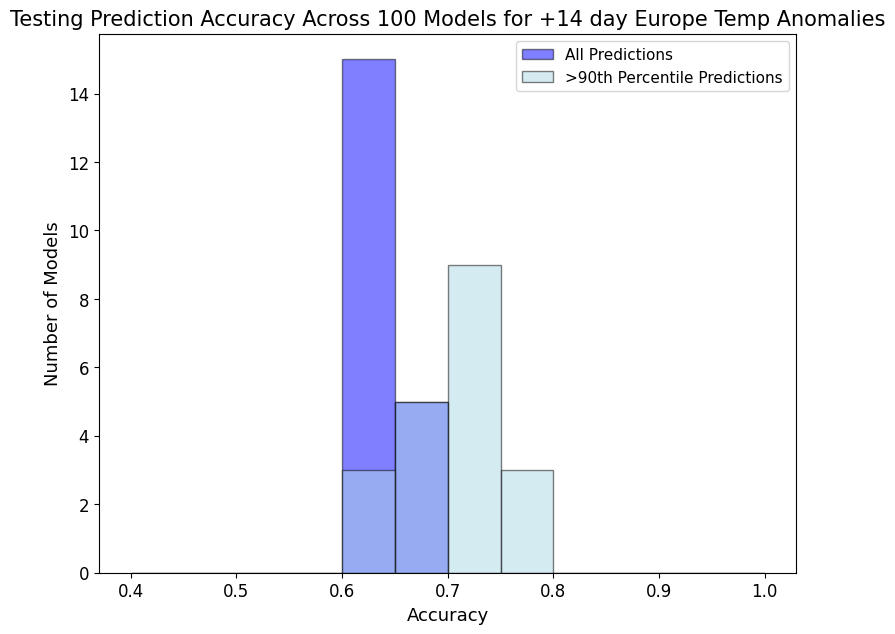

In [37]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
fig = plt.figure(figsize=(9,7))
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy', fontsize =13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Number of Models', fontsize =13)
plt.legend(fontsize = 11)
plt.title('Testing Prediction Accuracy Across 100 Models for +14 day Europe Temp Anomalies', fontsize =15)
#plt.savefig("EUR14_ACCtesting.png")

### SHAP Plots.

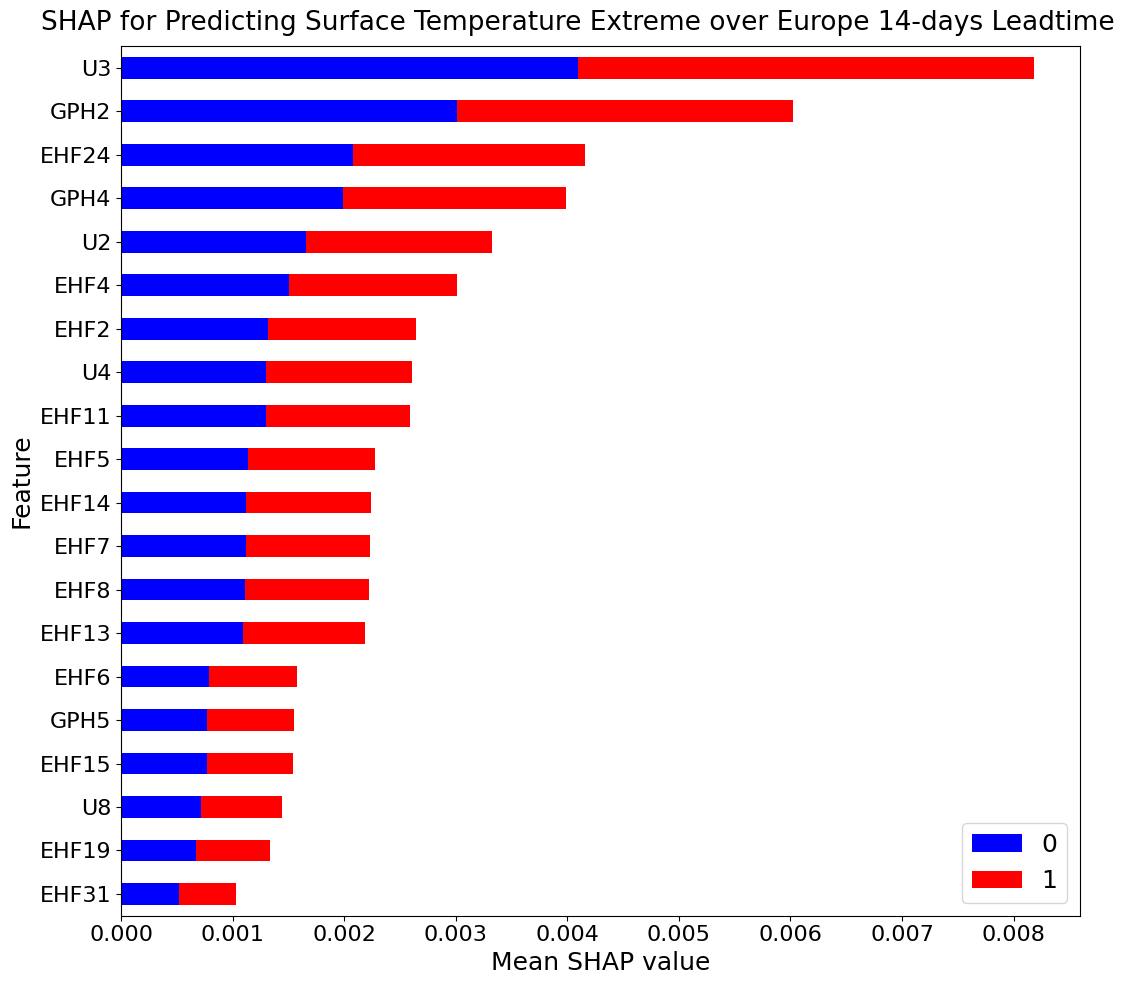

In [38]:
##shap bar plot. 
features = ['U3', 'GPH4', 'U2', 'GPH2', 'EHF2', 'GPH5', 'U4', 'EHF24', 'EHF19', 'EHF7',
            'EHF13', 'U8', 'EHF4', 'EHF31', 'EHF14', 'EHF11', 'EHF8', 'EHF15', 'EHF5', 'EHF6']

#take mean along CV axis
cat_shaps2 = np.nanmean(cat_shaps,axis=0)
feat_cat_df = pd.DataFrame(cat_shaps2) #make dataframs
feat_cat_df.columns = features #add labels
featcat_df = feat_cat_df.T #transpose
fig = plt.figure(figsize=(11,10),dpi=100)
fig.suptitle("SHAP for Predicting Surface Temperature Extreme over Europe 14-days Leadtime",
             fontsize = 19,x=.53) 
 
ax1 = fig.add_subplot(1,1,1)
featcat_df.loc[featcat_df.sum(1).sort_values(ascending=True).index[:]].plot(
    kind="barh", stacked=True, ax = ax1, colormap = 'bwr')
ax1.tick_params(axis='both', which='major', labelsize= 16)
#ax1.set_yticks([0,1,2,3,4,5,6,7,8],feature_name_bh)
ax1.set_xlabel('Mean SHAP value', fontsize =18 )
ax1.set_ylabel('Feature', fontsize =18 )
ax1.legend(loc = 'lower right', fontsize =18)
#ax1.set_xlim(0,0.25)

plt.tight_layout()
#plt.savefig('SHAP_barh_eur14.png')

In [39]:
#shap beeswarm, pre process
class0_agg = np.nanmean(class0_agg, axis=0)
class1_agg = np.nanmean(class1_agg, axis=0)
X_sample = np.mean(X_tr[:300], axis=1) #reference from training for agg shaps(samples, features)
#separate reference dataframe with column names. 
X_df = pd.DataFrame(X_sample, columns=features)

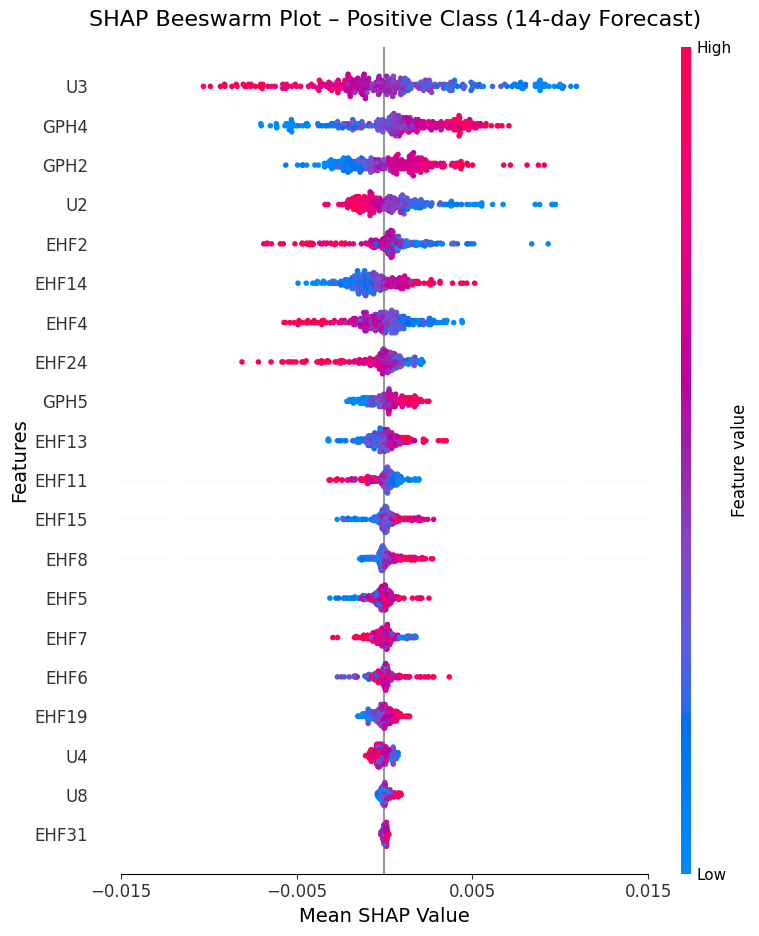

In [40]:
##Positive Beeswarm
shap.summary_plot(shap_class1_agg, X_df, show=False)
fig = plt.gcf()
ax = plt.gca()

fig.suptitle("SHAP Beeswarm Plot – Positive Class (14-day Forecast)", fontsize=16)
ax.set_xlabel("Mean SHAP Value", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
ax.set_xticks(np.arange(-0.015,0.02,0.01)) 
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
#plt.savefig("SHAP_beepos_eur14.png")
plt.show()

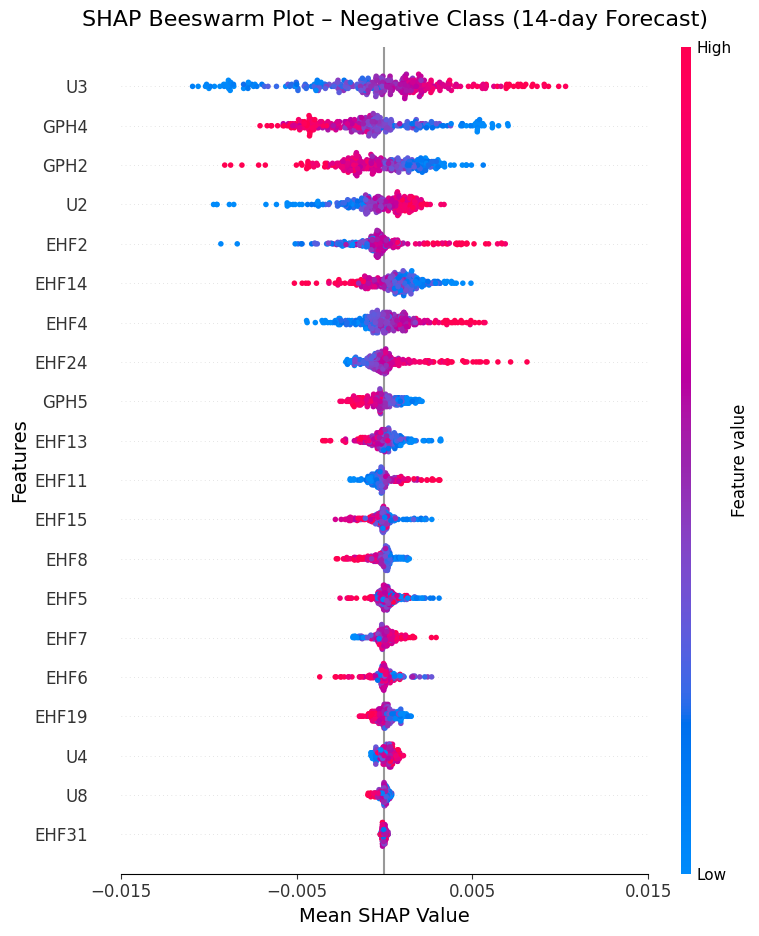

In [41]:
##negative beeswarm
shap.summary_plot(shap_class0_agg, X_df, show=False)
fig = plt.gcf()
ax = plt.gca()

fig.suptitle("SHAP Beeswarm Plot – Negative Class (14-day Forecast)", fontsize=16)
ax.set_xlabel("Mean SHAP Value", fontsize=14)
ax.set_xticks(np.arange(-0.015,0.02,0.01)) 
ax.set_ylabel("Features", fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
#plt.savefig("SHAP_beeneg_eur14.png")
plt.show()